In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os, time, copy 
import gc, json, random
from pathlib import Path

import itertools
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
%matplotlib inline

# ............................................
import warnings
warnings.filterwarnings('ignore')
!ls ../input/*

../input/1-cmi-target-sii-imputation-via-lgbm:
__notebook__.ipynb  __results__.html   custom.css
__output__.json     __results___files  train_sii.csv

../input/child-mind-institute-problematic-internet-use:
data_dictionary.csv    series_test.parquet   test.csv
sample_submission.csv  series_train.parquet  train.csv


In [2]:
# Notebook -1 >> >> 
dtrain = pd.read_csv('/kaggle/input/1-cmi-target-sii-imputation-via-lgbm/train_sii.csv', index_col='id')

# ...............................................................................................................
dtest = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col='id')
sub_sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

# ..............................................................................................................
dtrain_col = dtrain.columns.tolist()
dtest_col = dtest.columns.tolist()

dtrain.shape, dtest.shape, sub_sample.shape

((3960, 81), (20, 58), (20, 2))

In [3]:
# print('Duplicates in dtrain:', dtrain.duplicated().sum())
# print('Duplicates in dtest:', dtest.duplicated().sum())

# dtrain.drop_duplicates(inplace=True)
# dtrain.shape, dtest.shape

# .......................................................................
train = dtrain.copy()
test = dtest.copy()

train_col = train.columns.tolist()
test_col = test.columns.tolist()

# .......................................................................
len(train_col), train.isnull().mean()[:20] * 100

(81,
 Basic_Demos-Enroll_Season        0.000000
 Basic_Demos-Age                  0.000000
 Basic_Demos-Sex                  0.000000
 CGAS-Season                     35.479798
 CGAS-CGAS_Score                 38.863636
 Physical-Season                 16.414141
 Physical-BMI                    23.686869
 Physical-Height                 23.560606
 Physical-Weight                 22.323232
 Physical-Waist_Circumference    77.323232
 Physical-Diastolic_BP           25.404040
 Physical-HeartRate              25.075758
 Physical-Systolic_BP            25.404040
 Fitness_Endurance-Season        66.969697
 Fitness_Endurance-Max_Stage     81.237374
 Fitness_Endurance-Time_Mins     81.313131
 Fitness_Endurance-Time_Sec      81.313131
 FGC-Season                      15.505051
 FGC-FGC_CU                      41.363636
 FGC-FGC_CU_Zone                 42.373737
 dtype: float64)

## 📱Features

In [4]:
features = test_col.copy()
print('Number of Features :', len(features))

# Numerical Features
num_features = [f for f in features if train[f].dtype==float or f=='Basic_Demos-Age']
print('The number of numerical features :', len(num_features))

# Categorical Features
cat_features = [f for f in features if f not in num_features]
print('The number of categorical features :', len(cat_features))

# Target Features
target_col = [f for f in train_col if f not in test_col]
print('The number of target features :', len(target_col), '\n')

# Unique Number
pd.set_option('display.max_rows', 500)
pd.DataFrame(data= {'U_number train_cat': train[cat_features].nunique(), 
                    'U_number test_cat': test[cat_features].nunique()}).sort_values(by=['U_number train_cat']) 

Number of Features : 58
The number of numerical features : 47
The number of categorical features : 11
The number of target features : 23 



,U_number train_cat,U_number test_cat
Basic_Demos-Sex,2,2
Basic_Demos-Enroll_Season,4,4
CGAS-Season,4,4
Physical-Season,4,4
Fitness_Endurance-Season,4,3
FGC-Season,4,4
BIA-Season,4,3
PAQ_A-Season,4,1
PAQ_C-Season,4,4
SDS-Season,4,4


## 📱Features Imputation (для трейна & теста)

- Для числовых фич используется библиотека **KNNImputer**, а для категориальных фич для пропущенных значений создается новая категория под названием **"unknown"**.

In [5]:
from sklearn.impute import KNNImputer
imputer_num = KNNImputer(n_neighbors=2, weights="uniform")

# .........................................................................
df_data = pd.concat([train[features], test], axis=0)

imputer_num.fit(df_data[num_features])
df_data[num_features] = imputer_num.transform(df_data[num_features])

for col in cat_features:
    df_data[col] = df_data[col].fillna('unknown')
    df_data[col] = df_data[col].astype('category')

# .........................................................................
df_data.shape, df_data.isnull().mean()[:20] * 100 

((3980, 58),
 Basic_Demos-Enroll_Season       0.0
 Basic_Demos-Age                 0.0
 Basic_Demos-Sex                 0.0
 CGAS-Season                     0.0
 CGAS-CGAS_Score                 0.0
 Physical-Season                 0.0
 Physical-BMI                    0.0
 Physical-Height                 0.0
 Physical-Weight                 0.0
 Physical-Waist_Circumference    0.0
 Physical-Diastolic_BP           0.0
 Physical-HeartRate              0.0
 Physical-Systolic_BP            0.0
 Fitness_Endurance-Season        0.0
 Fitness_Endurance-Max_Stage     0.0
 Fitness_Endurance-Time_Mins     0.0
 Fitness_Endurance-Time_Sec      0.0
 FGC-Season                      0.0
 FGC-FGC_CU                      0.0
 FGC-FGC_CU_Zone                 0.0
 dtype: float64)

## 📱Pandas get_dummies & Preprocessing (для трейна & теста)

In [6]:
df_code = pd.get_dummies(df_data, columns=cat_features)

# ......................................................................
# StandardScaler
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_code[num_features] = scaler.fit_transform(df_code[num_features])

# ......................................................................
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_code[num_features] = scaler.fit_transform(df_code[num_features])

# ......................................................................
df_code.shape

(3980, 98)

## 📱Агрегация time series

- Статистика time series (например, среднее значение, стандартное отклонение) из данных **Actigraphy** вычисляется и объединяется с основным набором данных для создания дополнительных возможностей для обучения модели.

In [7]:
from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [8]:
# .....................................................................................................................
def process_file(filename, dirname):
    data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    data.drop('step', axis=1, inplace=True)
    return data.describe().values.reshape(-1), filename.split('=')[1]

# .....................................................................................................................
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    
    data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    data['id'] = indexes
    return data

# .....................................................................................................................
train_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
test_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove('id')

# .....................................................................................................................
train_ts.shape, test_ts.shape, len(time_series_cols)

100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


((996, 97), (2, 97), 96)

In [9]:
df_data_ts = pd.concat([train_ts, test_ts], axis=0)

# .........................................................................................
# StandardScaler
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_data_ts[time_series_cols] = scaler.fit_transform(df_data_ts[time_series_cols])

# .........................................................................................
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_data_ts[time_series_cols] = scaler.fit_transform(df_data_ts[time_series_cols])

# .........................................................................................
df_data_ts.shape

(998, 97)

In [10]:
df_code = df_code.reset_index()

train_df = df_code[:3960].copy()
test_df = df_code[3960:].copy()

train_df.shape, test_df.shape, df_code.shape

((3960, 99), (20, 99), (3980, 99))

In [11]:
train_ts = df_data_ts[:996].copy()
test_ts = df_data_ts[996:].copy()

train_ts.shape, test_ts.shape, df_data_ts.shape

((996, 97), (2, 97), (998, 97))

In [12]:
train_df = pd.merge(train_df, train_ts, how="left", on='id')
test_df = pd.merge(test_df, test_ts, how="left", on='id')

# ..................................................................
for col in time_series_cols:
    
    train_df[col] = train_df[col].fillna(train_df[col].median())
    test_df[col] = test_df[col].fillna(test_df[col].median())

# ..................................................................
train_df.shape, test_df.shape

((3960, 195), (20, 195))

## 📱Shapiro–Wilk тест

In [13]:
cols = train_df.columns.tolist()
cols.remove('id')

print('Number of all columns :', len(cols))

# ...........................................................
cols_select = []
alpha = 0.05

for col in cols:
    _, p_value = stats.shapiro(train_df[col])
    
    if (p_value <= alpha): 
        cols_select.append(col) 
    else:
        print('\t- Column deleted :', col)

# ...........................................................
print('\nNumber of selected columns :', len(cols_select))


Number of all columns : 194
	- Column deleted : stat_41
	- Column deleted : stat_42

Number of selected columns : 192


## 📱Корреляция фич

In [14]:
df_corr = train_df.copy()
df_corr['sii'] = train['sii'].values.copy()

# .............................................................
corr_sii = df_corr.corr(numeric_only=True)['sii']
corr_sii = corr_sii[(corr_sii > 0.03) | (corr_sii < -0.03)]

corr_list = corr_sii.keys().tolist()
corr_list.remove('sii')

len(corr_list)

95

In [15]:
y  = train['sii'].copy()
X  = train_df[corr_list].copy()
XX = test_df[corr_list].copy()

y.shape, X.shape, XX.shape

((3960,), (3960, 95), (20, 95))

# <span style="color:darkcyan;">၊၊||၊ LightGBM - Кросс-валидация</span>

<p style="border-bottom: 50px solid lightgreen"></p>

<p style="border-bottom: 15px solid darkcyan"></p>

In [16]:
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import ConfusionMatrixDisplay

- R-квадрат (R2 или коэффициент детерминации) - это статистический показатель в регрессионной модели, который определяет долю дисперсии зависимой переменной, которая может быть объяснена независимой переменной. Другими словами, r-квадрат показывает, насколько хорошо данные соответствуют регрессионной модели (степень соответствия).

In [17]:
base_model = lgb.LGBMRegressor(random_state=420, verbose=-1)
print('\nr2_score :', cross_val_score(base_model, X ,y ,cv=5, scoring='r2')) 


r2_score : [0.23734541 0.3165571  0.27619545 0.31719723 0.2186408 ]


## 🍀 Auxiliary Functions (вспомогательные функции)

In [18]:
# Rounding using thresholds
# Raw Predictions: pred_raw
# Rounded Predictions: pred
# Thresholds: t

def round_t(pred_raw, t):
    pred = np.where(pred_raw < t[0], 0, np.where(pred_raw < t[1], 1, np.where(pred_raw < t[2], 2, 3)))
    return pred

def qw_kappa(y_true, pred):
    return -cohen_kappa_score(y_true, pred, weights='quadratic')

# Thanks to: @ambrosm
def fun(t, y_true, pred_raw):
    pred = round_t(pred_raw, t)
    return -cohen_kappa_score(y_true, pred, weights='quadratic')

def optimized_thresholds(fun, y_true, pred_raw):
    res = minimize(fun, x0=[0.5, 1.5, 2.5], args=(y_true, pred_raw), method='Nelder-Mead')
    assert res.success
    return res.x.round(2) # optimized_thresholds

t = [0.6, 1.07, 2.52] # Optimized Thresholds (initial)

## 🍀 Гиперпараметры

In [19]:
# ::::::::::::::::::::::::::::::::::::::::::::::::
lgbm_params1 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.04,
    'max_depth'           : 12,
    'num_leaves'          : 59,
    'subsample'           : 0.70,
    'colsample_bytree'    : 0.50,
    'min_child_weight'    : 12, 
    'min_child_samples'   : 14,    
    'reg_alpha'           : 0.23,
    'reg_lambda'          : 0.36,
}

# ::::::::::::::::::::::::::::::::::::::::::::::::
lgbm_params2 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.05,
    'max_depth'           : 9,
    'num_leaves'          : 59,
    'subsample'           : 0.80,
    'colsample_bytree'    : 0.50,
    'min_child_weight'    : 12, 
    'min_child_samples'   : 14,  
    'reg_alpha'           : 0.23,
    'reg_lambda'          : 0.36,
}

# ::::::::::::::::::::::::::::::::::::::::::::::::
lgbm_params3 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.044,
    'max_depth'           : 12,
    'num_leaves'          : 478,
    'min_data_in_leaf'    : 13,
    'feature_fraction'    : 0.893,
    'bagging_fraction'    : 0.784,
    'bagging_freq'        : 4,
    'lambda_l1'           : 10, 
    'lambda_l2'           : 0.01, 
}

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

model1 = lgb.LGBMRegressor(**lgbm_params1, n_estimators=10000, random_state=421, early_stopping_rounds=350, verbose=-1)

model2 = lgb.LGBMRegressor(**lgbm_params2, n_estimators=10000, random_state=422, early_stopping_rounds=350, verbose=-1)

model3 = lgb.LGBMRegressor(**lgbm_params3, n_estimators=10000, random_state=423, early_stopping_rounds=350, verbose=-1)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

model_list = [model1, model2, model3]


## 🍀 Кросс-валидация

In [20]:
score_mean = 0
th = np.zeros(3)
pred = np.zeros(len(XX))
rkf = RepeatedKFold(n_splits=3, n_repeats=8, random_state=424)

for fold, (train_idx, valid_idx) in enumerate(rkf.split(X)):  
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]  

    print(f'\n:::::::::::::::::: Fold ~ {fold+1} :::::::::::::::::::')
    N = random.randrange(4) 
         
    if (N==0):
        print('LGBMRegressor - 1')
        model1.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])        
        oof = model1.predict(X_valid)
        prd = model1.predict(XX)
        
        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)
 
    if (N==1):
        print('LGBMRegressor - 2')
        model2.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])      
        oof = model2.predict(X_valid)
        prd = model2.predict(XX)
        
        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)
 
    if (N==2 or N==3):
        print('LGBMRegressor - 3')
        model3.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])        
        oof = model3.predict(X_valid)
        prd = model3.predict(XX) 
        
        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)
    
    score = cohen_kappa_score(y_valid, round_t(oof, th_opt), weights='quadratic')
    print('SCORE:', round(score, 4))
    
    th += np.array(th_opt)                          
    score_mean += score 
    pred += prd
    
score_mean = score_mean / rkf.get_n_splits(X, y)   
t = np.round(th / rkf.get_n_splits(X, y), 2)
preds_lgbm_raw = pred / rkf.get_n_splits(X, y)
preds_lgbm = round_t(preds_lgbm_raw, t)

print('\n', '='* 40)
print(' .'* 20)
print(' SCORE(mean):', score_mean, '\n')
print(' Optimized thresholds:', t)
print(' .'* 20)
print('='* 40, '\n')


:::::::::::::::::: Fold ~ 1 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.57 1.09 2.63]
SCORE: 0.4919

:::::::::::::::::: Fold ~ 2 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.59 1.04 2.78]
SCORE: 0.4818

:::::::::::::::::: Fold ~ 3 :::::::::::::::::::
LGBMRegressor - 2
th_opt = [0.53 1.48 2.43]
SCORE: 0.4313

:::::::::::::::::: Fold ~ 4 :::::::::::::::::::
LGBMRegressor - 2
th_opt = [0.51 1.14 3.29]
SCORE: 0.5142

:::::::::::::::::: Fold ~ 5 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.56 1.   2.68]
SCORE: 0.5106

:::::::::::::::::: Fold ~ 6 :::::::::::::::::::
LGBMRegressor - 1
th_opt = [0.51 1.51 2.45]
SCORE: 0.4089

:::::::::::::::::: Fold ~ 7 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.55 1.14 2.73]
SCORE: 0.5063

:::::::::::::::::: Fold ~ 8 :::::::::::::::::::
LGBMRegressor - 1
th_opt = [0.56 1.05 2.58]
SCORE: 0.5128

:::::::::::::::::: Fold ~ 9 :::::::::::::::::::
LGBMRegressor - 2
th_opt = [0.51 1.08 2.83]
SCORE: 0.5081

:::::::::::::::::: Fold ~ 10 :::::::

## 🍀 Саббмит - LGBM

In [21]:
sub_lgbm = sub_sample.copy()
sub_lgbm['sii'] = preds_lgbm

# ..............................................
sub_lgbm.to_csv('submission0.csv', index=False)
# Public Score : 0.452
print(preds_lgbm)
!ls

[1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0]
__notebook__.ipynb  submission0.csv


<p style="border-bottom: 50px solid lightgreen"></p>

<p style="border-bottom: 15px solid darkcyan"></p>

## <div style="color:yellow;display:inline-block;border-radius:5px;background-color:darkcyan;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b> </b>၊၊||၊ Notebook imported - 1</p></div>

### [Multi-Target Prediction](https://www.kaggle.com/code/tubotubo/starter-notebook-multi-target-prediction?scriptVersionId=197456007)



In [22]:
import warnings
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import polars as pl
import polars.selectors as cs
from catboost import CatBoostRegressor, MultiTargetCustomMetric
from numpy.typing import ArrayLike, NDArray
from polars.testing import assert_frame_equal
from sklearn.base import BaseEstimator
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore", message="Failed to optimize method")

DATA_DIR = Path("/kaggle/input/child-mind-institute-problematic-internet-use")
TARGET_COLS = [
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total",
    "sii",
]

FEATURE_COLS = [
    "Basic_Demos-Enroll_Season",
    "Basic_Demos-Age",
    "Basic_Demos-Sex",
    "CGAS-Season",
    "CGAS-CGAS_Score",
    "Physical-Season",
    "Physical-BMI",
    "Physical-Height",
    "Physical-Weight",
    "Physical-Waist_Circumference",
    "Physical-Diastolic_BP",
    "Physical-HeartRate",
    "Physical-Systolic_BP",
    "Fitness_Endurance-Season",
    "Fitness_Endurance-Max_Stage",
    "Fitness_Endurance-Time_Mins",
    "Fitness_Endurance-Time_Sec",
    "FGC-Season",
    "FGC-FGC_CU",
    "FGC-FGC_CU_Zone",
    "FGC-FGC_GSND",
    "FGC-FGC_GSND_Zone",
    "FGC-FGC_GSD",
    "FGC-FGC_GSD_Zone",
    "FGC-FGC_PU",
    "FGC-FGC_PU_Zone",
    "FGC-FGC_SRL",
    "FGC-FGC_SRL_Zone",
    "FGC-FGC_SRR",
    "FGC-FGC_SRR_Zone",
    "FGC-FGC_TL",
    "FGC-FGC_TL_Zone",
    "BIA-Season",
    "BIA-BIA_Activity_Level_num",
    "BIA-BIA_BMC",
    "BIA-BIA_BMI",
    "BIA-BIA_BMR",
    "BIA-BIA_DEE",
    "BIA-BIA_ECW",
    "BIA-BIA_FFM",
    "BIA-BIA_FFMI",
    "BIA-BIA_FMI",
    "BIA-BIA_Fat",
    "BIA-BIA_Frame_num",
    "BIA-BIA_ICW",
    "BIA-BIA_LDM",
    "BIA-BIA_LST",
    "BIA-BIA_SMM",
    "BIA-BIA_TBW",
    "PAQ_A-Season",
    "PAQ_A-PAQ_A_Total",
    "PAQ_C-Season",
    "PAQ_C-PAQ_C_Total",
    "SDS-Season",
    "SDS-SDS_Total_Raw",
    "SDS-SDS_Total_T",
    "PreInt_EduHx-Season",
    "PreInt_EduHx-computerinternet_hoursday",
]

In [23]:
# Load data
train = pl.read_csv(DATA_DIR / "train.csv")
test = pl.read_csv(DATA_DIR / "test.csv")
train_test = pl.concat([train, test], how="diagonal")

IS_TEST = test.height <= 100

assert_frame_equal(train, train_test[: train.height].select(train.columns))
assert_frame_equal(test, train_test[train.height :].select(test.columns))

# ....................................................................................
# Cast string columns to categorical
train_test = train_test.with_columns(cs.string().cast(pl.Categorical).fill_null("NAN"))
train = train_test[: train.height]
test = train_test[train.height :]

# ignore rows with null values in TARGET_COLS
train_without_null = train_test.drop_nulls(subset=TARGET_COLS)
X = train_without_null.select(FEATURE_COLS)
X_test = test.select(FEATURE_COLS)
y = train_without_null.select(TARGET_COLS)
y_sii = y.get_column("sii").to_numpy()  # ground truth
cat_features = X.select(cs.categorical()).columns

In [24]:
class MultiTargetQWK(MultiTargetCustomMetric):
    def get_final_error(self, error, weight):
        return np.sum(error)  # / np.sum(weight)

    def is_max_optimal(self):
        # if True, the bigger the better
        return True

    def evaluate(self, approxes, targets, weight):
        # approxes: 予測値 (shape: [ターゲット数, サンプル数])
        # targets: 実際の値 (shape: [ターゲット数, サンプル数])
        # weight: サンプルごとの重み (Noneも可)

        approx = np.clip(approxes[-1], 0, 3).round().astype(int)
        target = targets[-1]

        qwk = cohen_kappa_score(target, approx, weights="quadratic")

        return qwk, 1

    def get_custom_metric_name(self):
        return "MultiTargetQWK"


class OptimizedRounder:
    """
    A class for optimizing the rounding of continuous predictions into discrete class labels using Optuna.
    The optimization process maximizes the Quadratic Weighted Kappa score by learning thresholds that separate
    continuous predictions into class intervals.

    Args:
        n_classes (int): The number of discrete class labels.
        n_trials (int, optional): The number of trials for the Optuna optimization. Defaults to 100.

    Attributes:
        n_classes (int): The number of discrete class labels.
        labels (NDArray[np.int_]): An array of class labels from 0 to `n_classes - 1`.
        n_trials (int): The number of optimization trials.
        metric (Callable): The Quadratic Weighted Kappa score metric used for optimization.
        thresholds (List[float]): The optimized thresholds learned after calling `fit()`.

    Methods:
        fit(y_pred: NDArray[np.float_], y_true: NDArray[np.int_]) -> None:
            Fits the rounding thresholds based on continuous predictions and ground truth labels.

            Args:
                y_pred (NDArray[np.float_]): Continuous predictions that need to be rounded.
                y_true (NDArray[np.int_]): Ground truth class labels.

            Returns:
                None

        predict(y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
            Predicts discrete class labels by rounding continuous predictions using the fitted thresholds.
            `fit()` must be called before `predict()`.

            Args:
                y_pred (NDArray[np.float_]): Continuous predictions to be rounded.

            Returns:
                NDArray[np.int_]: Predicted class labels.

        _normalize(y: NDArray[np.float_]) -> NDArray[np.float_]:
            Normalizes the continuous values to the range [0, `n_classes - 1`].

            Args:
                y (NDArray[np.float_]): Continuous values to be normalized.

            Returns:
                NDArray[np.float_]: Normalized values.

    References:
        - This implementation uses Optuna for threshold optimization.
        - Quadratic Weighted Kappa is used as the evaluation metric.
    """

    def __init__(self, n_classes: int, n_trials: int = 100):
        self.n_classes = n_classes
        self.labels = np.arange(n_classes)
        self.n_trials = n_trials
        self.metric = partial(cohen_kappa_score, weights="quadratic")

    def fit(self, y_pred: NDArray[np.float_], y_true: NDArray[np.int_]) -> None:
        y_pred = self._normalize(y_pred)

        def objective(trial: optuna.Trial) -> float:
            thresholds = []
            for i in range(self.n_classes - 1):
                low = max(thresholds) if i > 0 else min(self.labels)
                high = max(self.labels)
                th = trial.suggest_float(f"threshold_{i}", low, high)
                thresholds.append(th)
            try:
                y_pred_rounded = np.digitize(y_pred, thresholds)
            except ValueError:
                return -100
            return self.metric(y_true, y_pred_rounded)

        optuna.logging.disable_default_handler()
        study = optuna.create_study(direction="maximize")
        study.optimize(
            objective,
            n_trials=self.n_trials,
        )
        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
        assert hasattr(self, "thresholds"), "fit() must be called before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: NDArray[np.float_]) -> NDArray[np.float_]:
        # normalize y_pred to [0, n_classes - 1]
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)

In [25]:
# setting catboost parameters
params = dict(
    loss_function="MultiRMSE",
    eval_metric=MultiTargetQWK(),
    iterations=1 if IS_TEST else 100000,
    learning_rate=0.1,
    depth=5,
    early_stopping_rounds=50,
)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)
models: list[CatBoostRegressor] = []
y_pred = np.full((X.height, len(TARGET_COLS)), fill_value=np.nan)
for train_idx, val_idx in skf.split(X, y_sii):
    X_train: pl.DataFrame
    X_val: pl.DataFrame
    y_train: pl.DataFrame
    y_val: pl.DataFrame
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # train model
    model = CatBoostRegressor(**params)
    model.fit(
        X_train.to_pandas(),
        y_train.to_pandas(),
        eval_set=(X_val.to_pandas(), y_val.to_pandas()),
        cat_features=cat_features,
        verbose=False,
    )
    models.append(model)

    # predict
    y_pred[val_idx] = model.predict(X_val.to_pandas())

assert np.isnan(y_pred).sum() == 0
# Optimize thresholds
optimizer = OptimizedRounder(n_classes=4, n_trials=300)
y_pred_total = y_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
optimizer.fit(y_pred_total, y_sii)
y_pred_rounded = optimizer.predict(y_pred_total)

# Calculate QWK
qwk = cohen_kappa_score(y_sii, y_pred_rounded, weights="quadratic")
print(f"Cross-Validated QWK Score: {qwk}")

Cross-Validated QWK Score: 0.38920729750397276


In [26]:
class AvgModel:
    def __init__(self, models: list[BaseEstimator]):
        self.models = models

    def predict(self, X: ArrayLike) -> NDArray[np.int_]:
        preds: list[NDArray[np.int_]] = []
        for model in self.models:
            pred = model.predict(X)
            preds.append(pred)

        return np.mean(preds, axis=0)

# ...............................................................................................
avg_model = AvgModel(models)
test_pred = avg_model.predict(X_test.to_pandas())[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
test_pred_rounded = optimizer.predict(test_pred)
test.select("id").with_columns(
    pl.Series("sii", pl.Series("sii", test_pred_rounded)),
).write_csv("submission1.csv")

# Public Score : 0.440
print(test_pred_rounded)
!ls

[0 0 2 0 1 2 2 1 3 1 1 1 3 1 3 1 0 1 0 2]
__notebook__.ipynb  catboost_info  submission0.csv  submission1.csv


<p style="border-bottom: 50px solid lightgreen"></p>

<p style="border-bottom: 15px solid darkcyan"></p>

## <div style="color:yellow;display:inline-block;border-radius:5px;background-color:darkcyan;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b> </b>၊၊||၊ Notebook imported - 2</p></div>

### [CMI - Detecting Problematic Digital Behavior](https://www.kaggle.com/code/lennarthaupts/cmi-detecting-problematic-digital-behavior)

- Thanks to : @lennarthaupts

In [27]:
import numpy as np
import pandas as pd
import os
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.optimize import minimize
from scipy import stats
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# ......................................................................................................
SEED = 42
n_splits = 10
optimize_params = False
n_trials = 25 # n_trials for optuna 
base_thresholds = [30, 50, 80]
y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition

# ......................................................................................................
# Load datasets
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')


In [28]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(),
    ]
    
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    no_mask = np.ones(len(df), dtype=bool)
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.diff().mean(), 
            data.diff().std()
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

# Code for parallelized computation of time series data from: Sheikh Muhammad Abdullah 
# https://www.kaggle.com/code/abdmental01/cmi-best-single-model
def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [29]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

train = train[train[y_comp].notna()] # Keep rows where target is available
train.shape

100%|██████████| 2/2 [00:00<00:00, 12.36it/s]


(2736, 155)

In [30]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']

features = [f for f in train.columns if f not in exclude]

# Categorical features
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

for col in cat_c:
    a_map = {}
    all_unique = set(train[col].unique()) | set(test[col].unique())
    for i, value in enumerate(all_unique):
        a_map[value] = i

    train[col] = train[col].map(a_map)
    test[col] = test[col].map(a_map)

In [31]:
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [32]:
# Code for finding optimal thresholds copied from: Michael Semenoff
# https://www.kaggle.com/code/michaelsemenoff/cmi-actigraphy-feature-engineering-selection
def round_with_thresholds(raw_preds, thresholds):
    return np.where(raw_preds < thresholds[0], int(0),
                    np.where(raw_preds < thresholds[1], int(1),
                             np.where(raw_preds < thresholds[2], int(2), int(3))))

def optimize_thresholds(y_true, raw_preds, start_vals=[0.5, 1.5, 2.5]):
    def fun(thresholds, y_true, raw_preds):
        rounded_preds = round_with_thresholds(raw_preds, thresholds)
        return -cohen_kappa_score(y_true, rounded_preds, weights='quadratic')

    res = minimize(fun, x0=start_vals, args=(y_true, raw_preds), method='Nelder-Mead')
    assert res.success
    return res.x

# .............................................................................................
def calculate_weights(series):
    # Create bins for the target variable and assign weights based on frequency
    bins = pd.cut(series, bins=10, labels=False)
    weights = bins.value_counts().reset_index()
    weights.columns = ['target_bins', 'count']
    weights['count'] = 1 / weights['count']
    weight_map = weights.set_index('target_bins')['count'].to_dict()
    weights = bins.map(weight_map)
    return weights / weights.mean() 


In [33]:
def cross_validate(model_, data, features, score_col, index_col, cv, sample_weights=False, verbose=False):
    """
    Perform cross-validation with a given model and compute the out-of-fold 
    predictions and Cohen's Kappa score for each fold.

    Returns:
    float: Mean Kappa score across all folds.
    array: Out-of-fold score predictions for the entire dataset.
    """
    kappa_scores = [] 
    oof_score_predictions = np.zeros(len(data))  

    score_to_index_thresholds = base_thresholds  

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(data, data[index_col])):
        X_train, X_val = data[features].iloc[train_idx], data[features].iloc[val_idx]
        y_train_score = data[score_col].iloc[train_idx]  
        y_val_score = data[score_col].iloc[val_idx]      
        y_val_index = data[index_col].iloc[val_idx]     
        
        # Train model with sample weights if provided
        if sample_weights:
            weights = calculate_weights(y_train_score)
            model_.fit(X_train, y_train_score, sample_weight=weights)
        else:
            model_.fit(X_train, y_train_score)
        
        y_pred_val_score = model_.predict(X_val)
        
        oof_score_predictions[val_idx] = y_pred_val_score 

        y_pred_val_index = round_with_thresholds(y_pred_val_score, score_to_index_thresholds)

        kappa_score = cohen_kappa_score(y_val_index, y_pred_val_index, weights='quadratic')
        kappa_scores.append(kappa_score)
        
        if verbose:
            print(f"Fold {fold_idx}: Kappa Score = {kappa_score}")
    
    if verbose:
        print(f"## Mean CV Kappa Score: {np.mean(kappa_scores)} ##")
    
    return np.mean(kappa_scores), oof_score_predictions

In [34]:
def objective(trial, model_type, X, features, score_col, index_col, cv, sample_weights=False):
    # Parameter space to explore if model is xgboost
    if model_type == 'xgboost':
        params = {
            'objective': trial.suggest_categorical('objective', ['reg:squarederror','reg:tweedie', 'reg:pseudohubererror']),
            'random_state': SEED,
            'n_estimators': trial.suggest_int('n_estimators', 300, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e-1),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e-1)
        }
        if params['objective'] == 'reg:tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = XGBRegressor(**params, use_label_encoder=False)
    
    # Parameter space to explore if model is lightgbm
    elif model_type == 'lightgbm':
        params = {
            'objective': trial.suggest_categorical('objective', ['poisson', 'tweedie', 'regression']),
            'random_state': SEED,
            'verbosity': -1,
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        if params['objective'] == 'tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = LGBMRegressor(**params)
    
    # Parameter space to explore if model is catboost
    elif model_type == 'catboost':
        params = {
            'loss_function': trial.suggest_categorical('objective', ['Tweedie:variance_power=1.5', 'Poisson', 'RMSE']),
            'random_state': SEED,
            'iterations': trial.suggest_int('iterations', 200, 600),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        }
        model = CatBoostRegressor(**params, verbose=0)
    
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    score, _ = cross_validate(model, X, features, score_col, index_col, cv, sample_weights=True, verbose=False)

    return score

def run_optimization(X, features, score_col, index_col, model_type, n_trials=30, cv=None, sample_weights=False):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_type, X, features, score_col, index_col, cv, sample_weights), 
                   n_trials=n_trials)
    
    print(f"Best params for {model_type}: {study.best_params}")
    print(f"Best score: {study.best_value}")
    return study.best_params

In [35]:
# Replace if subsets for features have been selected
lgb_features = features
xgb_features = features
cat_features = features

# ...........................................................................
# Parameters for LGBM, XGB and CatBoost
lgb_params = {
    'objective': 'tweedie', 
    'n_estimators': 242, 
    'max_depth': 4, 
    'learning_rate': 0.029229916231368648, 
    'subsample': 0.9435713052516868, 
    'colsample_bytree': 0.6372563562692964, 
    'tweedie_variance_power': 1.7598875942201002
}

xgb_params = {
    'objective': 'reg:tweedie', 
    'n_estimators': 554, 
    'max_depth': 3, 
    'learning_rate': 0.020148793517835852, 
    'subsample': 0.7245109070247534, 
    'colsample_bytree': 0.7516980111036932, 
    'gamma': 1.4405479996512962, 
    'reg_alpha': 0.00015467164351805926, 
    'reg_lambda': 0.011510449488765364, 
    'tweedie_variance_power': 1.2525085567413385
}

cat_params = {
    'objective': 'RMSE', 
    'iterations': 476, 
    'depth': 6, 
    'learning_rate': 0.01508021072978329, 
    'l2_leaf_reg': 0.009219274204258077, 
    'subsample': 0.909899776448952, 
    'bagging_temperature': 0.4068004305795976, 
    'random_strength': 0.13085860045085365, 
    'colsample_bylevel': 0.5000595287404359,
    'min_data_in_leaf': 27
}

# ...........................................................................
model = Lasso(alpha=0.3, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.3)
imputer.fit_models(model, train, features)
train = imputer.impute(train)
test = imputer.impute(test)

100%|██████████| 132/132 [00:02<00:00, 57.30it/s]


In [36]:
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

if optimize_params:
    # LightGBM Optimization
    lgb_params = run_optimization(train, lgb_features, y_model, y_comp, 'lightgbm', n_trials=n_trials, cv=kf, sample_weights=True)

    # XGBoost Optimization
    xgb_params = run_optimization(train, xgb_features, y_model, y_comp, 'xgboost', n_trials=n_trials, cv=kf, sample_weights=True)

    # CatBoost Optimization
    cat_params = run_optimization(train, cat_features, y_model, y_comp, 'catboost', n_trials=n_trials, cv=kf, sample_weights=True)

# ....................................................................................................................................
# Define models
lgb_model = LGBMRegressor(**lgb_params, random_state=SEED, verbosity=-1)
xgb_model = XGBRegressor(**xgb_params, random_state=SEED, verbosity=0)
cat_model = CatBoostRegressor(**cat_params, random_state=SEED, verbose=0)

weights = calculate_weights(train[y_model])

# Cross-validate LGBM model
score_lgb, oof_lgb = cross_validate(lgb_model, train, lgb_features, y_model, y_comp, kf, verbose=True, sample_weights=True)
lgb_model.fit(train[lgb_features], train[y_model], sample_weight=weights)
test_lgb = lgb_model.predict(test[lgb_features])

# Cross-validate XGBoost model
score_xgb, oof_xgb = cross_validate(xgb_model, train, xgb_features, y_model, y_comp, kf, verbose=True, sample_weights=True)
xgb_model.fit(train[xgb_features], train[y_model], sample_weight=weights)
test_xgb = xgb_model.predict(test[xgb_features])

# Cross-validate CatBoost model
score_cat, oof_cat = cross_validate(cat_model, train, cat_features, y_model, y_comp, kf, verbose=True, sample_weights=True)
cat_model.fit(train[cat_features], train[y_model], sample_weight=weights)
test_cat = cat_model.predict(test[cat_features])

print(f'Overall Mean Kappa: {np.mean([score_lgb, score_xgb, score_cat])}')


Fold 0: Kappa Score = 0.4141916098462961
Fold 1: Kappa Score = 0.4243697478991597
Fold 2: Kappa Score = 0.5517382413087935
Fold 3: Kappa Score = 0.5037854968936288
Fold 4: Kappa Score = 0.4444760617485949
Fold 5: Kappa Score = 0.4428046077786708
Fold 6: Kappa Score = 0.38960687960687956
Fold 7: Kappa Score = 0.3936916715888954
Fold 8: Kappa Score = 0.49340009103322713
Fold 9: Kappa Score = 0.46153846153846145
## Mean CV Kappa Score: 0.45196028692426077 ##
Fold 0: Kappa Score = 0.4450828937452902
Fold 1: Kappa Score = 0.444585551702242
Fold 2: Kappa Score = 0.5103528795063024
Fold 3: Kappa Score = 0.48399246704331444
Fold 4: Kappa Score = 0.36912999581373585
Fold 5: Kappa Score = 0.44520963165935157
Fold 6: Kappa Score = 0.3957973587567185
Fold 7: Kappa Score = 0.43212505384946764
Fold 8: Kappa Score = 0.459546925566343
Fold 9: Kappa Score = 0.4251207729468599
## Mean CV Kappa Score: 0.4410943530589626 ##
Fold 0: Kappa Score = 0.4075675675675675
Fold 1: Kappa Score = 0.44229731718083287

In [37]:
# Optimize thresholds for each model's OOF predictions
lgb_thresholds = optimize_thresholds(train[y_comp], oof_lgb, start_vals=base_thresholds)
print(f"LGBM optimized thresholds: {lgb_thresholds}")

xgb_thresholds = optimize_thresholds(train[y_comp], oof_xgb, start_vals=base_thresholds)
print(f"XGBoost optimized thresholds: {xgb_thresholds}")

cat_thresholds = optimize_thresholds(train[y_comp], oof_cat, start_vals=base_thresholds)
print(f"CatBoost optimized thresholds: {cat_thresholds}")

# Apply the optimized thresholds to OOF predictions
oof_lgb = round_with_thresholds(oof_lgb, lgb_thresholds)
oof_xgb = round_with_thresholds(oof_xgb, xgb_thresholds)
oof_cat = round_with_thresholds(oof_cat, cat_thresholds)
voted_oof = stats.mode(np.array([oof_lgb, oof_xgb, oof_cat]), axis=0).mode.flatten().astype(int)

# Calculate Kappa score for voted OOF predictions
kappa_score = cohen_kappa_score(train[y_comp], voted_oof, weights='quadratic')
print(f"Voted ensemble Kappa score: {kappa_score}")

# Apply the optimized thresholds to test predictions
test_lgb = round_with_thresholds(test_lgb, lgb_thresholds)
test_xgb = round_with_thresholds(test_xgb, xgb_thresholds)
test_cat = round_with_thresholds(test_cat, cat_thresholds)
voted_test = stats.mode(np.array([test_lgb, test_xgb, test_cat]), axis=0).mode.flatten().astype(int)

sub_mission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
sub_mission[y_comp] = voted_test
sub_mission.to_csv("submission2.csv", index=False)
# Public Score : 0.457
print(voted_test)
!ls

LGBM optimized thresholds: [31.0625     49.82638889 79.94444444]
XGBoost optimized thresholds: [33.54166667 49.29783951 69.24691358]
CatBoost optimized thresholds: [32.96606926 49.55039299 76.05931139]
Voted ensemble Kappa score: 0.46320547522491196
[1 0 1 0 1 1 0 0 2 1 1 1 1 1 1 1 0 0 0 1]
__notebook__.ipynb  submission0.csv  submission2.csv
catboost_info	    submission1.csv


<p style="border-bottom: 50px solid lightgreen"></p>

<p style="border-bottom: 15px solid darkcyan"></p>

## <div style="color:yellow;display:inline-block;border-radius:5px;background-color:darkcyan;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b> </b>၊၊||၊ Notebook imported - 3</p></div>

### [CMI Problematic Internet Use](https://www.kaggle.com/code/vishnupriyagarige/cmi-problematic-internet-use/notebook)

- Thanks to : @vishnupriyagarige

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder

from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor,LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize

# ................................................................................................................
train_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')


In [39]:
from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

def process_file(filename, dirname):
    data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    data.drop('step', axis=1, inplace=True)
    return data.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    data['id'] = indexes
    
    return data

# ......................................................................................................................
train_parquet = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_parquet = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_parquet.columns.tolist()
time_series_cols.remove("id")

100%|██████████| 2/2 [00:00<00:00, 12.63it/s]


In [40]:
train_data = pd.merge(train_data, train_parquet, how="left", on='id')
test_data = pd.merge(test_data, test_parquet, how="left", on='id')

# ............................................................................
train_data = train_data.drop('id',axis=1)
test_data = test_data.drop('id',axis=1)


In [41]:
# Example columns in your train and test data
train_columns = train_data.columns.tolist()  # Train columns including target
test_columns = test_data.columns.tolist()    # Test columns

# Identify common feature columns between train and test (excluding target)
common_columns = [col for col in train_columns if col in test_columns]

# Include the target column explicitly in the final train set
common_columns.append('sii')

# Now, reduce the training data to only the common feature columns + target
train_data = train_data[common_columns]

# Print the resulting columns in the training data
print("Train data columns:", len(train_data.columns))
print("Test data columns:", len(test_data.columns))

Train data columns: 155
Test data columns: 154


In [42]:
train_data = train_data.dropna(subset='sii')

num_cols = list(train_data.select_dtypes(exclude=['object']).columns.difference(['sii']))
cat_cols = list(train_data.select_dtypes(include=['object']).columns)

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns)
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

#num_cols_test = [col for col in num_cols_test if col not in ['id']]

# ...............................................................................................
for col in cat_cols:
    train_data[col] = train_data[col].fillna('missing')
    train_data[col] = train_data[col].astype('category')
    
    test_data[col] = test_data[col].fillna('missing')
    test_data[col] = test_data[col].astype('category')

# ...............................................................................................
for col in num_cols:
    train_data[col] = train_data[col].fillna(train_data[col].median())
    test_data[col] = test_data[col].fillna(test_data[col].median())


In [43]:
#  object datatype columns encoding:

labelencoder = LabelEncoder()
for col_name in cat_cols:
    train_data[col_name]=labelencoder.fit_transform(train_data[col_name]).astype(int)
        
for col_name in cat_cols_test:
    test_data[col_name]=labelencoder.transform(test_data[col_name]).astype(int)

# ..........................................................................................
scaler = StandardScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols] = scaler.transform(test_data[num_cols])

# ..........................................................................................
from sklearn.model_selection import train_test_split
X = train_data.drop(['sii'], axis=1)
y = train_data['sii']
test = test_data

In [44]:
params_lgb = {'learning_rate': 0.060210090165748686, 'n_estimators': 676, 'max_depth': 5, 'num_leaves': 193, 'min_child_weight': 1.4676211795900709, 'subsample': 0.9176759029661259, 'colsample_bytree': 0.6228483814299844, 'lambda_l1': 5.972758940714118, 'lambda_l2': 0.08520209502101517}
#Best QWK score: 0.4036
params_xgb = {'learning_rate': 0.07655257571702724, 'n_estimators': 688, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.8740939473627481, 'colsample_bytree': 0.9986562622011108, 'gamma': 0.005098593898531702, 'reg_alpha': 9.637641942675724, 'reg_lambda': 0.014395773764050573}
#Best QWK score: 0.4086
params_cat = {'iterations': 587, 'learning_rate': 0.055230940995657174, 'depth': 4, 'l2_leaf_reg': 0.00018791609018454318, 'subsample': 0.6500825893922675, 'colsample_bylevel': 0.9880985604359044, 'random_strength': 0.12043764855944512, 'bagging_temperature': 0.0008351502400011265, 'min_data_in_leaf': 21}
#Best QWK score: 0.3859

In [45]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [46]:
n_splits = 5
def train_model(model_class, test_data):
    
    X = train_data.drop(['sii'], axis=1)
    y = train_data['sii']
    test = test_data

    SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    models = []
    train_pred = []
    test_pred = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))
    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_pred.append(train_kappa)
        test_pred.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)
        models.append(model)

    print(f"Mean Train QWK : {np.mean(train_pred):.4f}")
    print(f"Mean Validation QWK : {np.mean(test_pred):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions, x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), method='Nelder-Mead') 
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    pred_mean = test_preds.mean(axis=1)
    pred = threshold_Rounder(pred_mean, KappaOPtimizer.x)
    
    submission = pd.DataFrame({'id': sample_data['id'],'sii': pred})

    return submission

In [47]:
!pip install colorama
from colorama import Fore, Style, init

# ............................................................................
# Create model instances
lgb_model = LGBMRegressor(**params_lgb, random_state=42, verbosity=-1)
XGB_Model = XGBRegressor(**params_xgb, random_state=42)
CatBoost_Model = CatBoostRegressor(**params_cat,verbose=0)

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[('lightgbm', lgb_model),
                                           ('xgboost', XGB_Model),
                                           ('catboost', CatBoost_Model)])

In [48]:
# Train the ensemble model
Sub_vote = train_model(voting_model, test)

# ...............................................
# Saving submission:
Sub_vote.to_csv('submission3.csv', index=False)
vote = Sub_vote['sii'].values.copy()
# Public Score : 0.464
print(vote)
!ls

Training Folds: 100%|██████████| 5/5 [00:31<00:00,  6.38s/it]

Mean Train QWK : 0.8068
Mean Validation QWK : 0.3963


Optimized QWK SCORE ::  0.454
[1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1]
__notebook__.ipynb  submission0.csv  submission2.csv
catboost_info	    submission1.csv  submission3.csv


<p style="border-bottom: 50px solid lightgreen"></p>

<p style="border-bottom: 15px solid darkcyan"></p>

## <div style="color:yellow;display:inline-block;border-radius:5px;background-color:darkcyan;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b> </b>၊၊||၊ Notebook imported - 4</p></div>

### [CMI | Best Single Model](https://www.kaggle.com/code/abdmental01/cmi-best-single-model)

- Thanks to : @abdmental01

In [49]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

In [50]:
def feature_engineering(df):
    #season_cols = [col for col in df.columns if 'Season' in col]
    #df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    #df['Age_Weight'] = df['Basic_Demos-Age'] * df['Physical-Weight']
    df['BMI_HeartRate'] = df['Physical-BMI'] * df['Physical-HeartRate']
    return df

In [51]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_HeartRate', ]

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

100%|██████████| 2/2 [00:00<00:00, 12.01it/s]


Train Shape : (2736, 171) || Test Shape : (20, 170)


In [52]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission,model

In [53]:
Params7 = {'learning_rate': 0.03884249148676395, 'max_depth': 12, 'num_leaves': 413, 'min_data_in_leaf': 14,
           'feature_fraction': 0.7987976913702801, 'bagging_fraction': 0.7602261703576205, 'bagging_freq': 2, 
           'lambda_l1': 4.735462555910575, 'lambda_l2': 4.735028557007343e-06} # CV : 0.4094 | LB : 0.471

Light = lgb.LGBMRegressor(**Params7,random_state=SEED, verbose=-1,n_estimators=200)
Submission,model = TrainML(Light,test)


Training Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]

Mean Train QWK --> 0.8447
Mean Validation QWK ---> 0.3901


----> || Optimized QWK SCORE ::  0.451


In [54]:
Submission.to_csv('submission4.csv', index=False)
single = Submission['sii'].values.copy()
# PB : 0.471
print(single)
!ls

[0 0 0 1 0 2 0 0 1 0 0 0 1 1 1 1 0 0 0 1]
__notebook__.ipynb  submission0.csv  submission2.csv  submission4.csv
catboost_info	    submission1.csv  submission3.csv


<p style="border-bottom: 50px solid lightgreen"></p>

<p style="border-bottom: 15px solid darkcyan"></p>

## <div style="color:yellow;display:inline-block;border-radius:5px;background-color:darkcyan;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b> </b>၊၊||၊ End to End</p></div>
## Энсемблируем решения всех ноутбуков

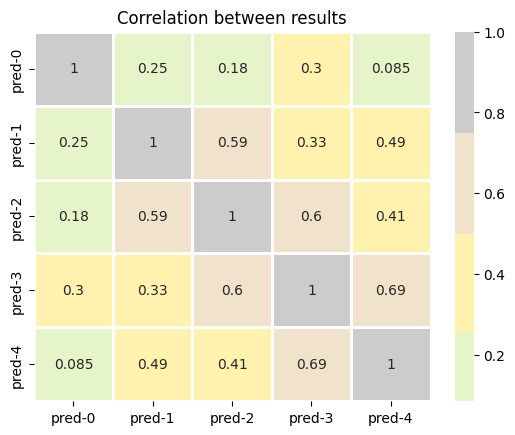

In [55]:
score_list = [0.452, 0.440, 0.457, 0.464, 0.475]
preds_list = [preds_lgbm, test_pred_rounded, voted_test, vote, single]

# ..........................................................................
result_corr = pd.DataFrame({
    'pred-0': preds_list[0],
    'pred-1': preds_list[1],
    'pred-2': preds_list[2],
    'pred-3': preds_list[3],
    'pred-4': preds_list[4],
})

df_corr = result_corr.corr()
sns.heatmap(df_corr, center=0, annot=True, cmap='Pastel2', linewidths=1)
plt.title('Correlation between results')
plt.show()

In [56]:
preds_list = [preds_lgbm, test_pred_rounded, voted_test, vote, single]

# ..........................................................................
pr_blend = stats.mode(preds_list)[0] 
count_pr_blend = stats.mode(preds_list)[1]

sub_blend = sub_sample.copy()
sub_blend['sii'] = pr_blend.copy()    
sub_blend.to_csv('submission.csv', index=False)
# Public Score: 0.483

# ..........................................................................
print(pr_blend)
print(count_pr_blend)
!ls

[1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1]
[3 5 3 3 4 3 3 3 2 4 3 3 4 4 4 5 5 4 5 3]
__notebook__.ipynb  submission.csv   submission1.csv  submission3.csv
catboost_info	    submission0.csv  submission2.csv  submission4.csv


<p style="border-bottom: 50px solid lightgreen"></p>

<p style="border-bottom: 15px solid darkcyan"></p>